# Demand Forecasting

This notebook focuses on forecasting the demand level for crops based on historical data, price trends, weather conditions, and other factors.

## Objectives
1. Load and explore the demand dataset.
2. Visualize demand trends by Time, Season, and Market.
3. **Heuristic Demand Classification**: Derive demand based on Price & Arrivals.
4. Preprocess the data.
5. Train a Machine Learning model to predict `demand_level`.
6. Evaluate the model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")

## 1. Load Data

In [3]:
# Load the dataset
file_path = 'demand_forecasting_dataset.csv'
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,date,commodity_group,crop_type,state_name,market_location,total_quantity_sold,avg_price_per_kg,historical_demand_7d,price_trend_7d,estimated_production_kg,policy_support_score,festival_flag,season,weather_index,demand_level,demand_category
0,2023-01-01,Millet,Jowar (Sorghum),Andhra Pradesh,Banaganapalli,1000.0,29.00,900.0,29.00,480000.0,0.99,1,Rabi,0.50,100.0,Low
1,2023-01-01,Millet,Jowar (Sorghum),Andhra Pradesh,Alur,10.0,28.60,10.0,28.60,480000.0,0.80,1,Rabi,0.59,10.0,Low
2,2023-01-02,Oilseed,Castor Seed,Andhra Pradesh,Kurnool,10800.0,62.05,9720.0,62.05,100000.0,0.76,1,Rabi,0.64,1188.0,Medium
3,2023-01-02,Oilseed,Sunflower,Andhra Pradesh,Kurnool,2300.0,61.89,2070.0,61.89,90000.0,0.72,1,Rabi,0.55,1127.0,Medium
4,2023-01-02,Millet,Jowar (Sorghum),Andhra Pradesh,Banaganapalli,1000.0,29.00,900.0,29.00,480000.0,0.85,1,Rabi,0.52,100.0,Low


## 2. EDA & Visualization

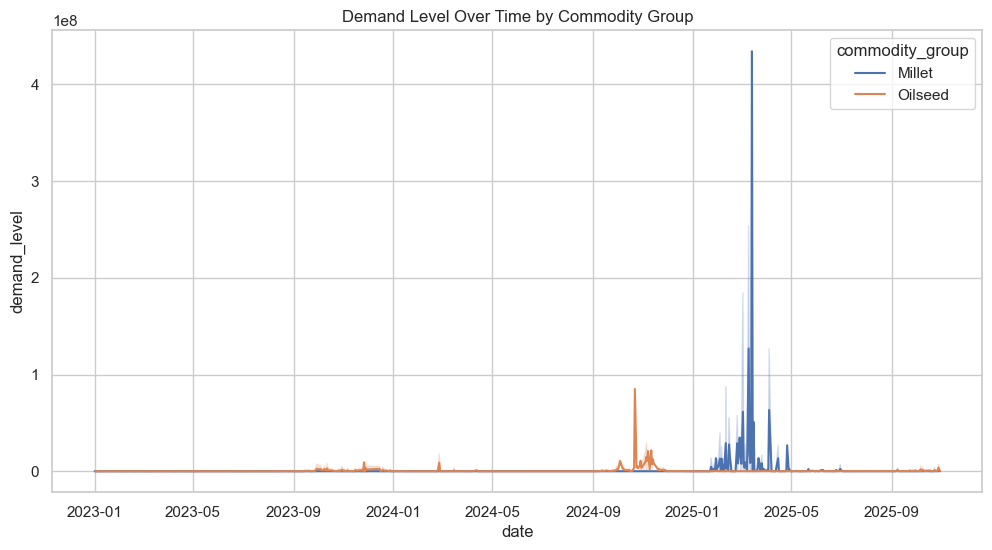

C:\Users\jahna\AppData\Local\Temp\ipykernel_16044\1612429725.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='season', y='demand_level', ci=None, palette='viridis')
C:\Users\jahna\AppData\Local\Temp\ipykernel_16044\1612429725.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='season', y='demand_level', ci=None, palette='viridis')


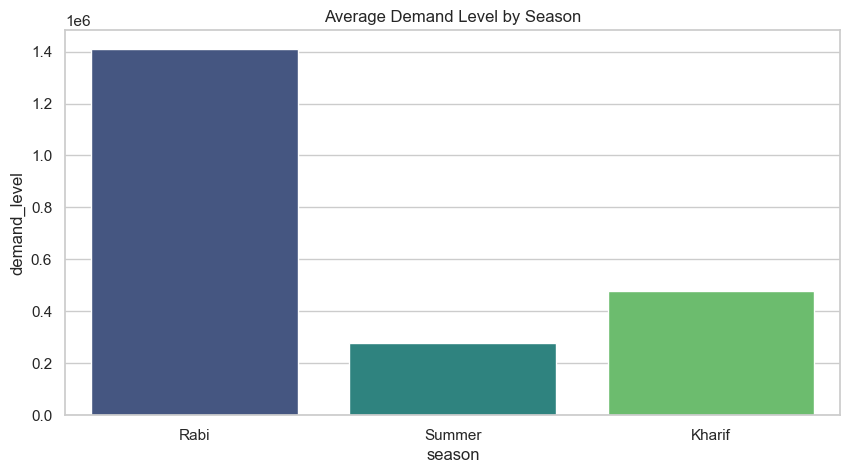

In [4]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Plot Demand Level over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='demand_level', hue='commodity_group')
plt.title('Demand Level Over Time by Commodity Group')
plt.show()

# Demand by Season
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='season', y='demand_level', ci=None, palette='viridis')
plt.title('Average Demand Level by Season')
plt.show()
 

## 2.1 Heuristic Demand Classification

A farmer can estimate demand by comparing current **Mandi Prices** and **Arrivals (Quantity)** relative to the seasonal and market average.

**Logic:**
- **High Demand**: High Price (> Average) AND Low Arrivals (< Average). Scarcity drives price up.
- **Low Demand**: Low Price (< Average) AND High Arrivals (> Average). Surplus drives price down.
- **Medium Demand**: Other combinations (High Price/High Arrivals or Low Price/Low Arrivals).

C:\Users\jahna\AppData\Local\Temp\ipykernel_16044\3903116424.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='market_location', y='demand_level', palette='magma')


Text(0.5, 1.0, 'Average Demand Level by Market Location (Log Scale)')

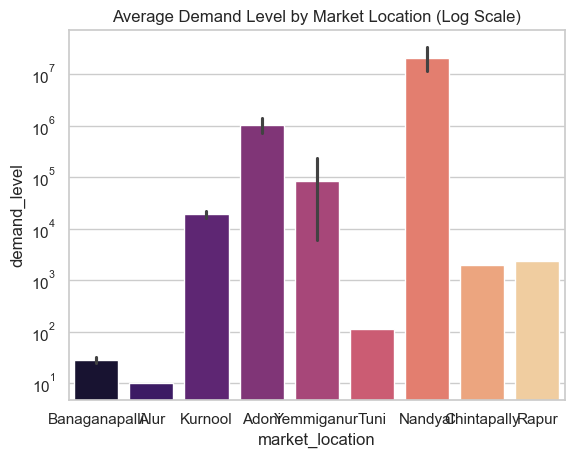

In [8]:
sns.barplot(data=df, x='market_location', y='demand_level', palette='magma')
plt.yscale('log')  # <--- Add this line
plt.title('Average Demand Level by Market Location (Log Scale)')

In [6]:
# 1. Calculate Group Averages (Benchmarks)
group_cols = ['season', 'market_location', 'crop_type']
# Calculating mean Price and Quantity for each Season-Market-Crop group
market_stats = df.groupby(group_cols)[['avg_price_per_kg', 'total_quantity_sold']].mean().reset_index()

# Rename to avoid collision
market_stats.rename(columns={'avg_price_per_kg': 'grp_avg_price', 'total_quantity_sold': 'grp_avg_qty'}, inplace=True)

# 2. Merge benchmarks back into the main dataframe
df = df.merge(market_stats, on=group_cols, how='left')

# 3. Define Heuristic Function
def classify_heuristic_demand(row):
    price = row['avg_price_per_kg']
    qty = row['total_quantity_sold']
    mean_p = row['grp_avg_price']
    mean_q = row['grp_avg_qty']
    
    # High Price & Low Arrivals -> High Demand
    if price > mean_p and qty < mean_q:
        return 'High'
    # Low Price & High Arrivals -> Low Demand
    elif price < mean_p and qty > mean_q:
        return 'Low'
    # Default to Medium for other quadrants (e.g. High Price + High Supply = Strong Market)
    else:
        return 'Medium'

# Apply logic
df['heuristic_demand_category'] = df.apply(classify_heuristic_demand, axis=1)

print("Heuristic Demand Classification Sample:")
print(df[['date', 'market_location', 'avg_price_per_kg', 'grp_avg_price', 'total_quantity_sold', 'grp_avg_qty', 'heuristic_demand_category']].head())

Heuristic Demand Classification Sample:
        date market_location  avg_price_per_kg  grp_avg_price  \
0 2023-01-01   Banaganapalli             29.00      33.067039   
1 2023-01-01            Alur             28.60      30.662893   
2 2023-01-02         Kurnool             62.05      55.859667   
3 2023-01-02         Kurnool             61.89      43.453155   
4 2023-01-02   Banaganapalli             29.00      33.067039   

   total_quantity_sold   grp_avg_qty heuristic_demand_category  
0               1000.0    352.905028                       Low  
1                 10.0     10.000000                    Medium  
2              10800.0  20605.833333                      High  
3               2300.0   3535.119048                      High  
4               1000.0    352.905028                       Low  


C:\Users\jahna\AppData\Local\Temp\ipykernel_30220\446784881.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='heuristic_demand_category', order=['Low', 'Medium', 'High'], palette='coolwarm')


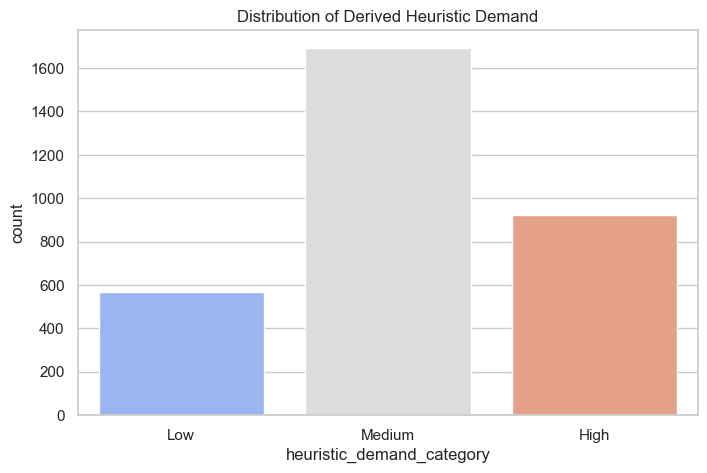

In [17]:
# Visualize the Heuristic Results
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='heuristic_demand_category', order=['Low', 'Medium', 'High'], palette='coolwarm')
plt.title('Distribution of Derived Heuristic Demand')
plt.show()


Comparison with dataset 'demand_category' labels:
heuristic_demand_category  High  Low  Medium
demand_category                             
High                        190  413     457
Low                         247   79     742
Medium                      486   73     492


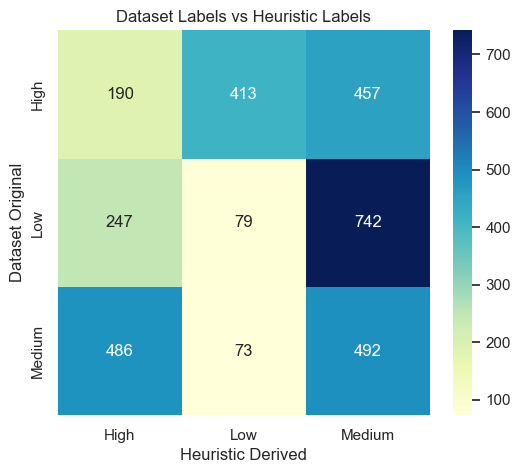

In [18]:
# Compare with Original Dataset Label (if available)
if 'demand_category' in df.columns:
    print("\nComparison with dataset 'demand_category' labels:")
    ct = pd.crosstab(df['demand_category'], df['heuristic_demand_category'])
    print(ct)
    
    # Heatmap of confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Dataset Labels vs Heuristic Labels')
    plt.xlabel('Heuristic Derived')
    plt.ylabel('Dataset Original')
    plt.show()

## 3. Preprocessing

In [19]:
# Extract temporal features
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

# Drop original date column and target-related/derived columns not for training
# We retain 'grp_avg_price' and 'grp_avg_qty' as they are valid historical features
drop_cols = ['date', 'demand_category', 'heuristic_demand_category']
df_train = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [20]:
# Encode Categorical Variables
categorical_cols = ['commodity_group', 'crop_type', 'state_name', 'market_location', 'season']
label_encoders = {}

for col in categorical_cols:
    if col in df_train.columns:
        le = LabelEncoder()
        df_train[col] = le.fit_transform(df_train[col])
        label_encoders[col] = le

df_train.head()

,commodity_group,crop_type,state_name,market_location,total_quantity_sold,avg_price_per_kg,historical_demand_7d,price_trend_7d,estimated_production_kg,policy_support_score,festival_flag,season,weather_index,demand_level,grp_avg_price,grp_avg_qty,month,day_of_week
0,0,3,0,2,1000.0,29.00,900.0,29.00,480000.0,0.99,1,1,0.50,100.0,33.067039,352.905028,1,6
1,0,3,0,1,10.0,28.60,10.0,28.60,480000.0,0.80,1,1,0.59,10.0,30.662893,10.000000,1,6
2,1,1,0,4,10800.0,62.05,9720.0,62.05,100000.0,0.76,1,1,0.64,1188.0,55.859667,20605.833333,1,0
3,1,7,0,4,2300.0,61.89,2070.0,61.89,90000.0,0.72,1,1,0.55,1127.0,43.453155,3535.119048,1,0
4,0,3,0,2,1000.0,29.00,900.0,29.00,480000.0,0.85,1,1,0.52,100.0,33.067039,352.905028,1,0


## 4. Model Training

In [21]:
# Define Features (X) and Target (y)
X = df_train.drop(columns=['demand_level'])
y = df_train['demand_level']

# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (2543, 17)
Testing shape: (636, 17)


In [22]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

## 5. Evaluation

In [23]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Root Mean Squared Error (RMSE): 9551285.25
R^2 Score: 0.72


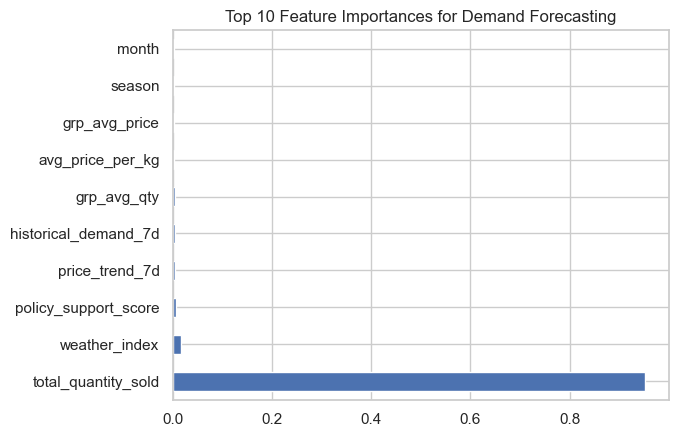

In [24]:
# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances for Demand Forecasting')
plt.show()